# <font color=#5b797e> Figure 3 | Spinal cord func / morphometry coupling </font>
<hr style="border:1px solid black">

to read: https://elifesciences.org/articles/62116

### Imports

In [9]:
import sys,json
import glob, os
import pandas as pd
import numpy as np
from palettable.colorbrewer.sequential import GnBu_9
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

#statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
from scipy.stats import spearmanr

main_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project"
sys.path.append(main_dir + "/code/")
from structural.structural_metrics import StructuralMetrics
from brsc_statistics import Statistics 

from plotting import Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load config file ------------------------------------------------------------
config_file=main_dir + '/config/03_brsc_sfc.json' # the notebook should be in 'xx/notebook/' folder #config_proprio
with open(config_file) as config_f: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_f)
    
plot=Plotting(config_file,"test")
stat_func=Statistics(config=config,ana_dir="",analysis="")

IDs=config["participants_IDs_ALL"]
structure="spinalcord"
output_dir= config["project_dir"] +"/figures/f02_functional_sc/fc_tps_coupling/figures"
metadata = pd.read_csv(config["project_dir"] + config["population_infos"], delimiter='\t')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<hr style="border:1px solid black">

### <font color=#5b797e> A. Load data
#### <font color=#5b797e> A.1 Matrices (TPS and FC)

In [10]:
files={};matrix={};df_matrix_all={};age=[];sex=[]

#---- Initiate variables
for modality in ["func_tp","func_fc"]:
    #----- Load indiv data
    files[modality]=[];matrix[modality]=[]
    for ID_nb, ID in enumerate(IDs):
        files[modality].append(glob.glob(config["project_dir"] + config[modality]["analysis_dir"]["spinalcord"] + config[modality]["first_level"]["global"].format(ID))[0])
        matrix[modality].append(np.array(pd.read_csv(files[modality][ID_nb],header=None)))

        if modality=="func_tp":
            age.append(metadata[metadata["participant_id"] == ID]["age"].values[0])
            sex.append(metadata[metadata["participant_id"] == ID]["sex"].values[0])
    matrix[modality] =np.array( matrix[modality]) 
    
    #---- Load group data and filter the dataframe
    df_matrix_all[modality]=pd.read_csv(glob.glob(config["project_dir"] + config[modality]["analysis_dir"]["spinalcord"] + config[modality]["second_level_matrix"])[0])     

# ----- Grouped all matrix in the same DF
all_df=df_matrix_all["func_tp"];all_df["fc"]=df_matrix_all["func_fc"]["fcorr"];
all_df["rois"] = all_df["seed1"] + "_" + all_df["seed2"]

#### <font color=#5b797e> A.2 Load features values (temporal profile and fc)

In [11]:
df_metrics_all={};df_metrics_reduced={};
for modality in ["func_tp","func_fc",]:
    
    #---- Load group data and filter the dataframe
    df_metrics_all[modality]=pd.read_csv(glob.glob(config["project_dir"] + config[modality]["analysis_dir"]["spinalcord"] + config[modality]["second_level_metrics"])[0])
        
    if modality=="func_tp":
        functional_features = df_metrics_all[modality].columns[np.r_[8:11,12:19,20:33]] # select feature columns
    else:
        df_metrics_all[modality]=df_metrics_all["func_fc"].groupby(["IDs","group","age","sex","labels1","level_labels"])["fcorr"].mean().reset_index()
        df_metrics_all[modality]=df_metrics_all["func_fc"][df_metrics_all["func_fc"]["labels1"].isin(["ventral","dorsal"])].reset_index(drop=True)

#----- merge structural and functional df
df_metrics_VD=df_metrics_all["func_tp"].groupby(["IDs","age","sex","ventro_dorsal","levels"])[list(functional_features)].mean().reset_index()
df_metrics_VD["fc"]=df_metrics_all["func_fc"]["fcorr"]

#--- Reduce the df by one value / participant
df_metrics_VD_reduced=df_metrics_VD.groupby(["ventro_dorsal","levels"])[list(functional_features) + ['fc']].mean().reset_index()

### <font color=#5b797e> B. FC and temporal similarity coupling
#### <font color=#5b797e> B.1 Global effect

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project/code/brsc_statistics.py:111: RuntimeWarning: Mean of empty slice
  m1_all = np.stack(matrix1); m1_mean=np.nanmean(m1_all,axis=0)
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project/code/brsc_statistics.py:112: RuntimeWarning: Mean of empty slice
  m2_all = np.stack(matrix2); m2_mean=np.nanmean(m2_all,axis=0)
/export02/data/landelle/anaconda/envs/CL_brsc_aging_env_py10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/export02/data/landelle/anaconda/envs/CL_brsc_aging_env_py10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.586640608830102
4.262392462634431e-71


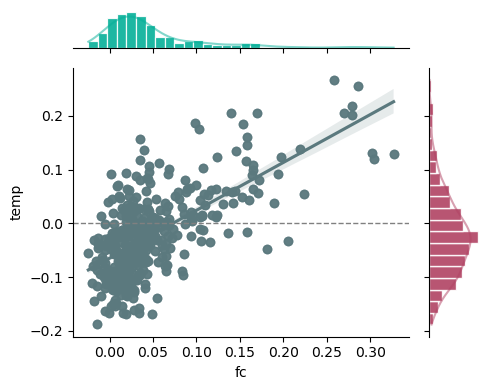

In [12]:
df_fc_temp,data_fc_temp=stat_func.compute_regional_coupling(matrix1=matrix["func_fc"][:, :, :],matrix2=matrix["func_tp"][:, :, :],metrics=["fc","temp"],df_out=True,metadata_df=metadata)

r_value, p_value = spearmanr(data_fc_temp['fc'], data_fc_temp["temp"])
print(r_value); print(p_value)
data_fc_temp["fc_ln"]=np.log(data_fc_temp["fc"])
data_fc_temp["temp_ln"]=np.log(data_fc_temp["temp"])
plot.regplots(df=data_fc_temp,x_data="fc",y_data="temp",reg_color="#5b797e",x_color="#04AF98",y_color="#B14263",
             save=False,output_f=output_dir + "/figures/fc_temp_coupling")




/export02/data/tmp/ipykernel_3950921/3402246770.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


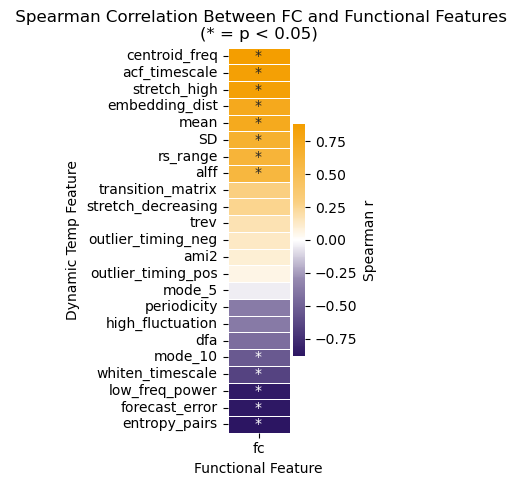

In [14]:

#---- Compute spearman correlation between each temporal and functional features
results_df = {}; significant= {}
results=[]
df=df_metrics_VD_reduced
for s_feat in functional_features:
    for f_feat in ['fc']:
        r, p = spearmanr(df[s_feat], df[f_feat], nan_policy='omit')
        results.append({"functional_feature": s_feat,
                             'fc': f_feat,
                             "spearman_r": r,
                             "p_value": p})
results_df = pd.DataFrame(results)
significant = results_df[results_df["p_value"] < 0.05].sort_values(by="spearman_r", ascending=False)


#---- Plot the results in a heatmap
colors = ["#2C1562","#61508A","#968AB1","#FFFFFF","#FACF80","#F7B740","#F49E00"]  # blue → white → red
custom_cmap = LinearSegmentedColormap.from_list("my_colormap", colors)

# Pivot matrix for heatmap values (Spearman r)
heatmap_data = results_df.pivot_table(columns='fc',index='functional_feature',values='spearman_r')
annot_data = results_df.pivot_table(columns='fc',index='functional_feature',values='p_value')
annot_stars = annot_data.map(lambda p: '*' if p < 0.05 else '') # Annotate with "*" where p < 0.05, else blank

heatmap_data = heatmap_data.sort_index()
annot_stars = annot_stars.sort_index()
heatmap_data = heatmap_data.sort_values(by='fc', ascending=False)
annot_stars = annot_stars.reindex(index=heatmap_data.index)

# Plot heatmap
plt.figure(figsize=(1, 5))
sns.heatmap(heatmap_data,annot=annot_stars,fmt='s',center=0,linewidths=0.5,cbar_kws={'label': 'Spearman r'},
           cmap=custom_cmap)

plt.title(' Spearman Correlation Between FC and Functional Features\n(* = p < 0.05)')
plt.xlabel('Functional Feature')
plt.ylabel('Dynamic Temp Feature')
plt.tight_layout()
plt.show()


#### <font color=#5b797e> B.2 Age effect

0.1411294555685421
0.005985909523175303


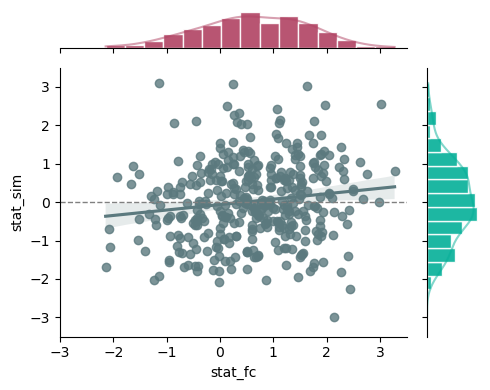

The figure has been saved to /cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project//figures/f02_functional_sc/fc_tps_coupling/figures/fc_temp_coupling_age.pdf


In [18]:
roi_results_fc=[];roi_results_sim=[]

# compute age effect by roi
for roi in all_df["rois"].unique():
    df_roi_metrics=all_df[all_df["rois"]==roi]
    signed_r2_2, p_age2,p_sex2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y="fc",predictor="age",covariates=["sex"])
    roi_results_fc.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
    signed_r2_2, p_age2, p_sex2,beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y="sim",predictor="age",covariates=["sex"])
    roi_results_sim.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
    
    roi_results_fc_df= pd.DataFrame(roi_results_fc)
    roi_results_sim_df= pd.DataFrame(roi_results_sim)

# convert the results in a DF
all_age_eff=pd.DataFrame({"rois":roi_results_fc_df["rois"],
            "stat_fc":roi_results_fc_df["tvalue_age"],
            "stat_sim":roi_results_sim_df["tvalue_age"]})

# Compute spearman correlation between tvalues
r_value, p_value = spearmanr(all_age_eff["stat_fc"], all_age_eff["stat_sim"])
print(r_value); print(p_value)

# plot the results
plot.regplots(df=all_age_eff,x_data="stat_fc",y_data="stat_sim",reg_color="#5b797e",x_color="#B14263",y_color="#04AF98"
              ,ymin=-3.5, ymax=3.5,xmin=-3, xmax=3.5, save=True,output_f=output_dir + "/fc_temp_coupling_age")

### <font color=#5b797e> C Coupling between FC and each features
#### <font color=#5b797e> C.1 Global coupling between FC and each features


In [18]:
selected_cols = np.r_[8:11,12:19,20:33]
functional_features = temp_df_local.columns[selected_cols]

temp_df_local_VD=temp_df_local.groupby(["IDs","age","sex","levels","ventro_dorsal"], as_index=False)[functional_features].mean()
#temp_df_local_RL=temp_df_local.groupby(["IDs","age","sex","right_left","levels"], as_index=False)[functional_features].mean()
fc_df_VD_all=fc_df[(fc_df["labels1"].isin(["ventral","dorsal"])&(fc_df["betwith_labels"]=="intra"))]
fc_df_VD=fc_df_VD_all.groupby(["IDs","age","sex","level_labels","labels1"], as_index=False)["fcorr"].mean()
df_merged = pd.merge(temp_df_local_VD,fc_df_VD.rename(columns={"labels1": "ventro_dorsal","level_labels":"levels"}),on=["IDs","age","sex","levels","ventro_dorsal"], how="inner")
df_merged["rois"]=df_merged["levels"]+"_"+df_merged["ventro_dorsal"]
df_merged

,IDs,age,sex,levels,ventro_dorsal,mode_5,mode_10,acf_timescale,ami2,trev,...,entropy_pairs,rs_range,dfa,low_freq_power,forecast_error,mean,SD,alff,fcorr,rois
0,A001,58,F,C1,dorsal,-0.855066,-1.043270,-0.878430,0.848232,0.838060,...,0.596657,0.595692,-0.073498,0.951346,0.864722,1.003357,0.951516,0.591343,0.133337,C1_dorsal
1,A001,58,F,C1,ventral,-0.552755,0.702119,-0.220109,0.180519,-1.038827,...,0.234106,-1.167169,1.076531,0.485186,0.148122,0.892776,1.349018,0.685866,0.373308,C1_ventral
2,A001,58,F,C2,dorsal,-0.749607,0.443646,1.697189,0.518122,-0.155947,...,-1.038171,0.527890,-0.799832,-1.579234,-1.766548,0.666673,1.117852,0.432445,0.329278,C2_dorsal
3,A001,58,F,C2,ventral,-0.030075,-0.117726,-0.722498,0.579672,-0.112582,...,0.237812,-0.285739,-0.860360,0.485186,0.346926,0.703844,1.407688,0.921769,0.125418,C2_ventral
4,A001,58,F,C3,dorsal,0.300682,-1.024619,-1.149377,-0.570162,0.543899,...,0.745019,1.341518,-0.194554,0.951346,0.265190,0.657685,-0.065808,0.724116,0.422953,C3_dorsal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,P109,56,M,C5,ventral,0.519428,-0.859260,-0.471775,1.093837,-0.635165,...,0.442265,0.690745,-0.510310,0.219532,0.618759,-1.039913,-0.903926,-1.060246,0.119439,C5_ventral
934,P109,56,M,C6,dorsal,0.051283,0.692952,-0.971701,0.597648,0.214110,...,0.739737,0.598645,-0.102062,1.160385,1.051007,-0.325976,-0.834523,-0.336551,-0.018392,C6_dorsal
935,P109,56,M,C6,ventral,-0.385505,-0.694418,-0.200096,-1.459883,-0.003303,...,-0.387673,0.138149,0.510310,0.407703,0.172881,-0.945196,-0.763809,-1.080332,0.027568,C6_ventral
936,P109,56,M,C7,dorsal,1.184988,-0.261691,0.062535,-0.235653,-0.185765,...,-0.379585,0.874943,1.428869,0.156809,0.309515,-1.737305,-1.315749,-1.738331,0.095207,C7_dorsal


In [19]:
df=df_merged.groupby(["levels"], as_index=False)[np.append(functional_features, 'fcorr')].mean()
correlations=[]; p_values=[]
for feat in functional_features:
    r_value, p_value = spearmanr(df[feat], df["fcorr"])
    correlations.append(r_value)
    p_values.append(p_value)

results_df = pd.DataFrame({
    'feature': functional_features,
    'r_with_fcorr': correlations,
    'p_value': p_values
})
results_df_sorted = results_df.sort_values(by='r_with_fcorr', ascending=False)

/export02/data/tmp/ipykernel_3733995/987953418.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


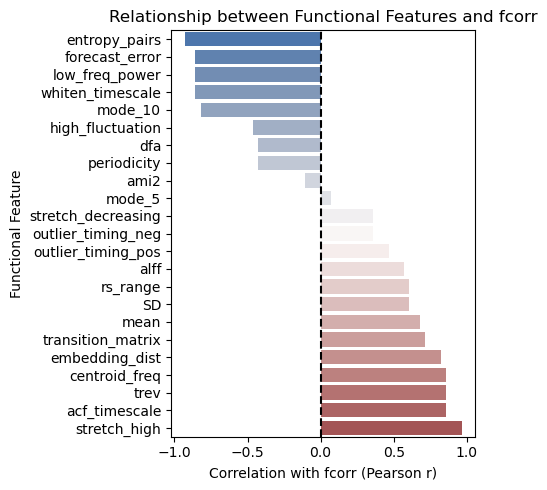

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort by correlation
results_df_sorted = results_df.sort_values(by='r_with_fcorr', ascending=True)

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(
    data=results_df_sorted,
    x='r_with_fcorr',
    y='feature',
    palette='vlag'  # Blue-red gradient
)

plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Correlation with fcorr (Pearson r)')
plt.ylabel('Functional Feature')
plt.title('Relationship between Functional Features and fcorr')
plt.tight_layout()
plt.show()


In [21]:
df_merged#["rois"].unique()

,IDs,age,sex,levels,ventro_dorsal,mode_5,mode_10,acf_timescale,ami2,trev,...,entropy_pairs,rs_range,dfa,low_freq_power,forecast_error,mean,SD,alff,fcorr,rois
0,A001,58,F,C1,dorsal,-0.855066,-1.043270,-0.878430,0.848232,0.838060,...,0.596657,0.595692,-0.073498,0.951346,0.864722,1.003357,0.951516,0.591343,0.133337,C1_dorsal
1,A001,58,F,C1,ventral,-0.552755,0.702119,-0.220109,0.180519,-1.038827,...,0.234106,-1.167169,1.076531,0.485186,0.148122,0.892776,1.349018,0.685866,0.373308,C1_ventral
2,A001,58,F,C2,dorsal,-0.749607,0.443646,1.697189,0.518122,-0.155947,...,-1.038171,0.527890,-0.799832,-1.579234,-1.766548,0.666673,1.117852,0.432445,0.329278,C2_dorsal
3,A001,58,F,C2,ventral,-0.030075,-0.117726,-0.722498,0.579672,-0.112582,...,0.237812,-0.285739,-0.860360,0.485186,0.346926,0.703844,1.407688,0.921769,0.125418,C2_ventral
4,A001,58,F,C3,dorsal,0.300682,-1.024619,-1.149377,-0.570162,0.543899,...,0.745019,1.341518,-0.194554,0.951346,0.265190,0.657685,-0.065808,0.724116,0.422953,C3_dorsal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,P109,56,M,C5,ventral,0.519428,-0.859260,-0.471775,1.093837,-0.635165,...,0.442265,0.690745,-0.510310,0.219532,0.618759,-1.039913,-0.903926,-1.060246,0.119439,C5_ventral
934,P109,56,M,C6,dorsal,0.051283,0.692952,-0.971701,0.597648,0.214110,...,0.739737,0.598645,-0.102062,1.160385,1.051007,-0.325976,-0.834523,-0.336551,-0.018392,C6_dorsal
935,P109,56,M,C6,ventral,-0.385505,-0.694418,-0.200096,-1.459883,-0.003303,...,-0.387673,0.138149,0.510310,0.407703,0.172881,-0.945196,-0.763809,-1.080332,0.027568,C6_ventral
936,P109,56,M,C7,dorsal,1.184988,-0.261691,0.062535,-0.235653,-0.185765,...,-0.379585,0.874943,1.428869,0.156809,0.309515,-1.737305,-1.315749,-1.738331,0.095207,C7_dorsal


mode_5
-0.1384615384615385
0.6368849912650183


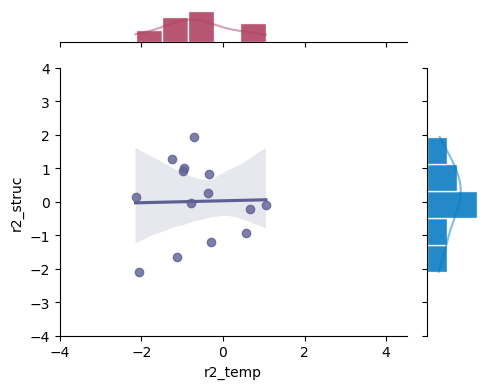

mode_10
-0.2527472527472528
0.3833149644785111


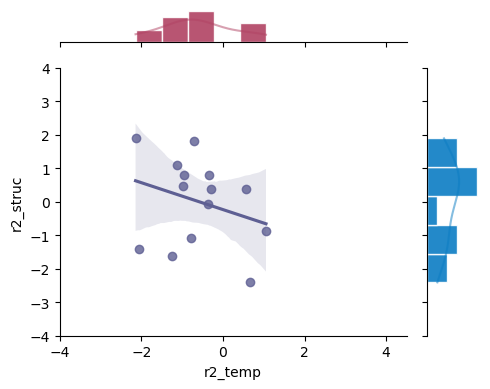

acf_timescale
0.04175824175824176
0.8872869731890637


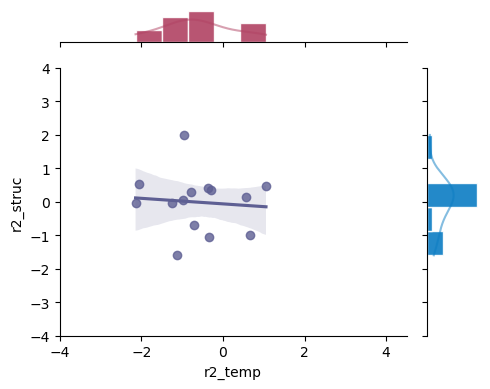

ami2
-0.18681318681318684
0.5225040123791591


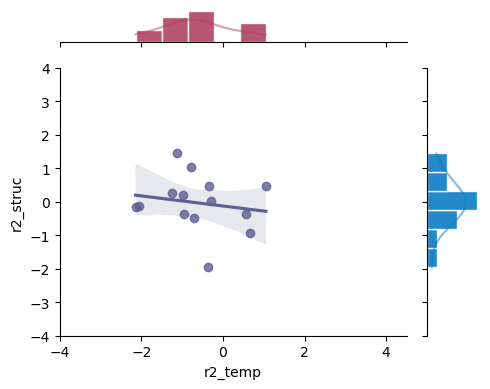

trev
-0.2835164835164835
0.32596594744177265


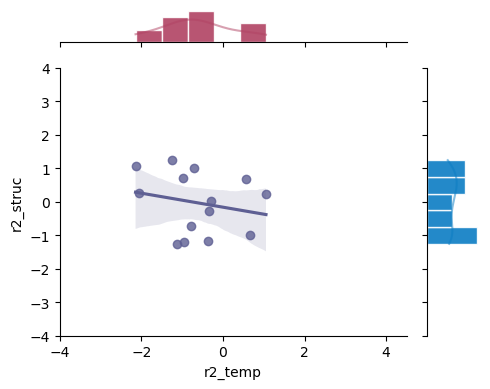

high_fluctuation
-0.02857142857142857
0.9227613765698746


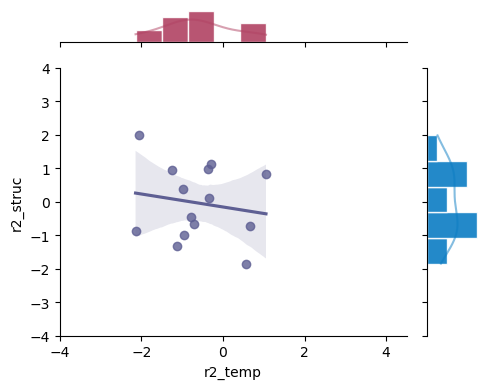

stretch_high
-0.16043956043956045
0.5837527526413409


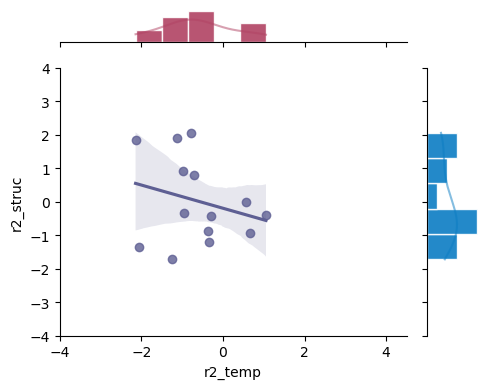

transition_matrix
0.0857142857142857
0.7707850311186757


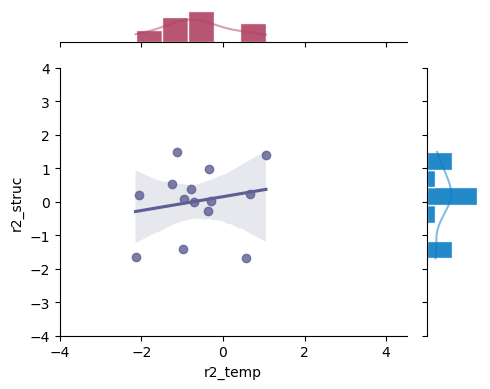

periodicity
-0.13406593406593406
0.6477195279851131


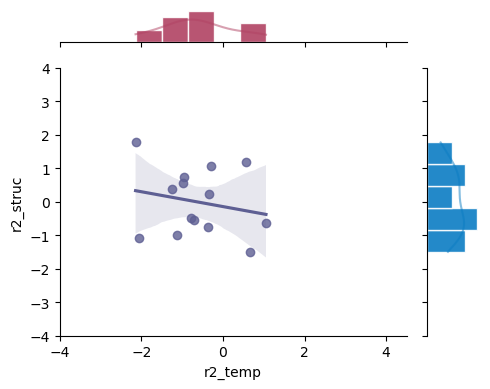

embedding_dist
-0.04175824175824176
0.8872869731890637


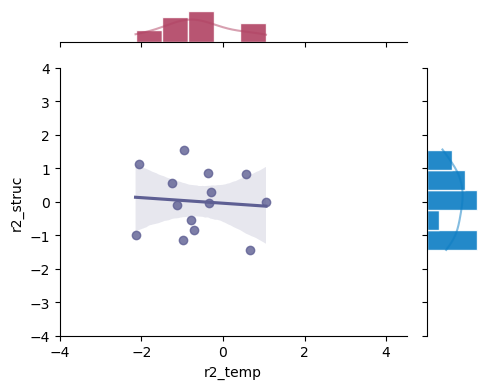

whiten_timescale
-0.1164835164835165
0.6916912502331573


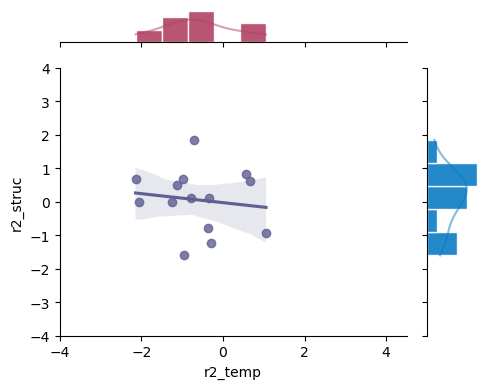

outlier_timing_pos
0.08131868131868132
0.7822747512440957


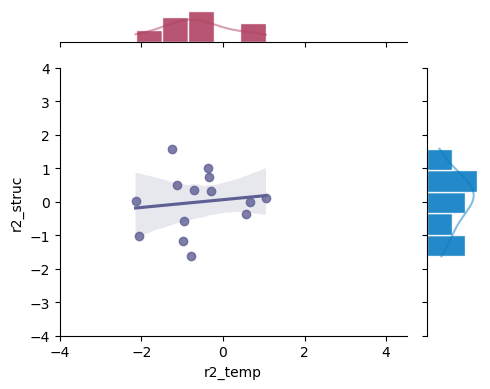

outlier_timing_neg
0.2703296703296703
0.3499193863496043


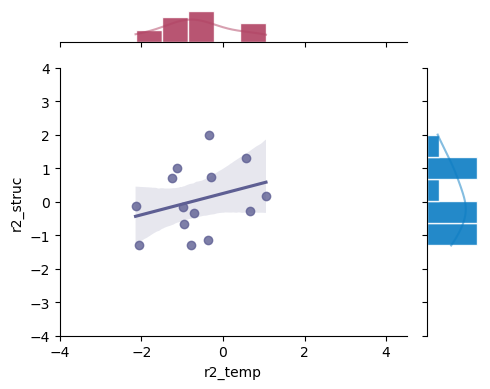

centroid_freq
-0.1032967032967033
0.725282211088945


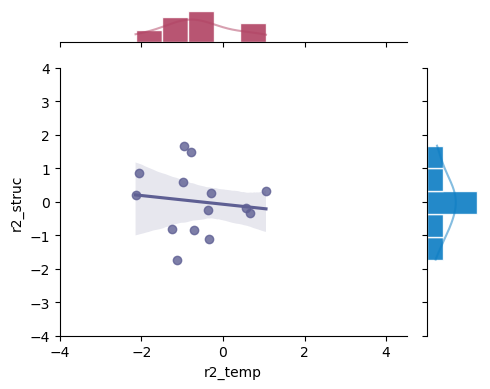

stretch_decreasing
0.11208791208791209
0.7028331631967695


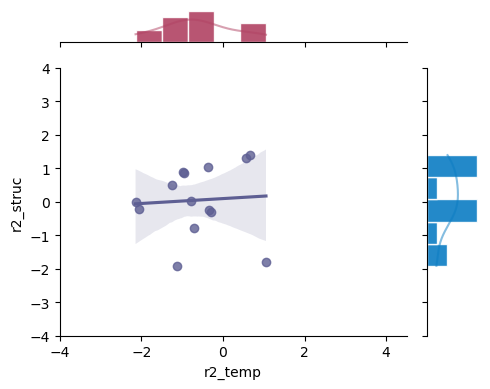

entropy_pairs
0.3450549450549451
0.2269486800417005


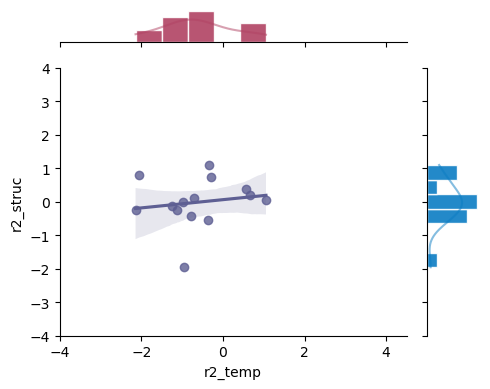

rs_range
0.389010989010989
0.16921738979769044


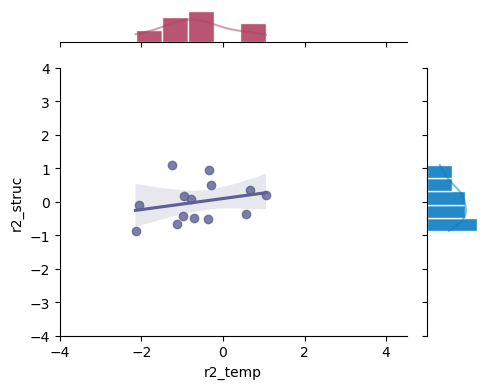

dfa
0.1384615384615385
0.6368849912650183


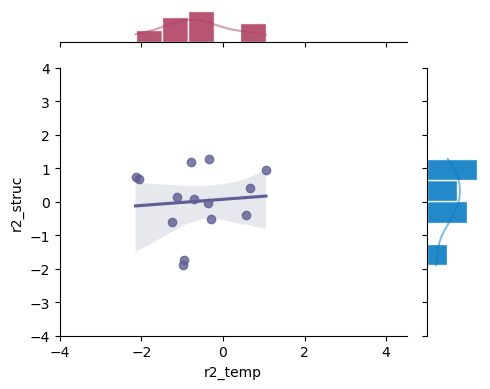

low_freq_power
-0.1076923076923077
0.7140308087262492


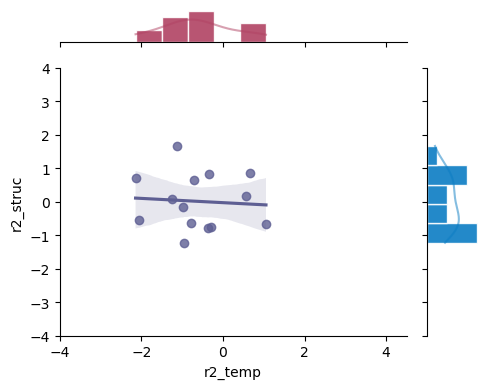

forecast_error
-0.07252747252747253
0.8053763135410923


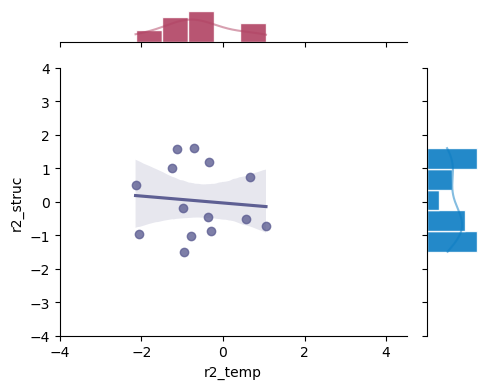

mean
0.432967032967033
0.12201000596848025


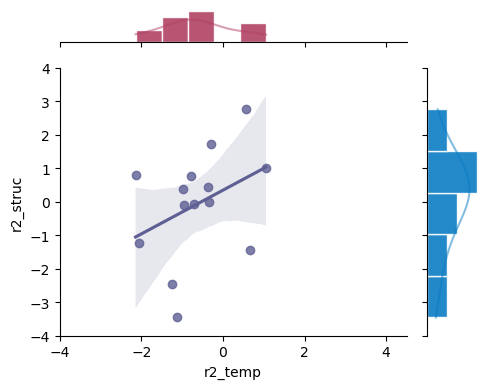

SD
0.38461538461538464
0.17450875077509556


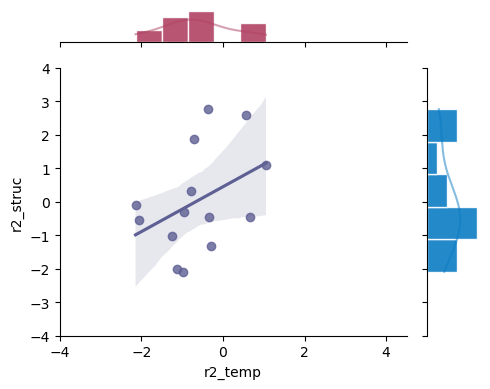

alff
0.5736263736263736
0.03197081397639698


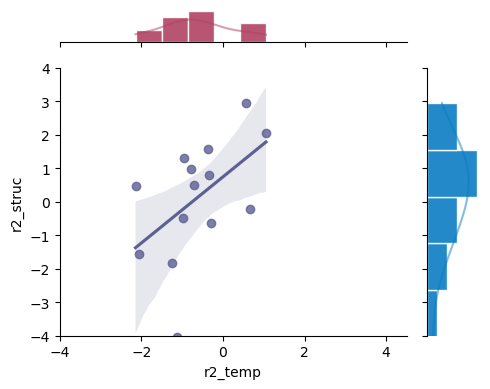

In [23]:

for feat in functional_features:
    print(feat)
    roi_results_fc=[];roi_results_sim=[]
    for roi in df_merged["rois"].unique():
        df_roi_metrics=df_merged[df_merged["rois"]==roi]
        signed_r2_2, p_age2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y="fcorr",predictor="age",covariates=["sex"])
        roi_results_fc.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
        
        signed_r2_2, p_age2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics,y=feat,predictor="age",covariates=["sex"])
        roi_results_sim.append({"rois":roi,"signed_r2": signed_r2_2,"p_age": p_age2,"beta_age": beta_age2,"beta_sex": beta_sex2,"tvalue_age": stat_age2,"tvalue_sex": stat_sex2})
        
        roi_results_fc_df= pd.DataFrame(roi_results_fc)
        roi_results_sim_df= pd.DataFrame(roi_results_sim)
        
        all_age_eff=pd.DataFrame({"rois":roi_results_fc_df["rois"],
                "r2_temp":roi_results_fc_df["tvalue_age"],
                "r2_struc":roi_results_sim_df["tvalue_age"]})
    
    
    r_value, p_value = spearmanr(all_age_eff["r2_temp"], all_age_eff["r2_struc"])
    print(r_value); print(p_value)
    
    
    plot.regplots(df=all_age_eff,x_data="r2_temp",y_data="r2_struc",reg_color="#5e5f93",x_color="#B14263",y_color="#0B7CC3"
                  , ymin=-4, ymax=4,xmin=-4, xmax=4.5)


In [227]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

correlations = []
p_values = []

for i in range(len(functional_features)):
    r, p = pearsonr(t_age_fc, t_age_feat[:, i])
    correlations.append(r)
    p_values.append(p)

p_fdr = fdrcorrection(p_values)[1]

results_df = pd.DataFrame({
    'feature': functional_features,
    'r_with_fc_age_effect': correlations,
    'p_value': p_values,
    'p_fdr': p_fdr
}).sort_values('r_with_fc_age_effect', ascending=False)

print(results_df)


               feature  r_with_fc_age_effect   p_value     p_fdr
15       entropy_pairs              0.636996  0.123907  0.984711
7    transition_matrix              0.574851  0.177005  0.984711
17                 dfa              0.468076  0.289478  0.984711
12  outlier_timing_neg              0.434073  0.330509  0.984711
5     high_fluctuation              0.407818  0.363773  0.984711
11  outlier_timing_pos              0.394209  0.381534  0.984711
3                 ami2              0.275019  0.550568  0.984711
16            rs_range              0.263134  0.568593  0.984711
4                 trev              0.247094  0.593208  0.984711
9       embedding_dist              0.048789  0.917272  0.984711
2        acf_timescale              0.009006  0.984711  0.984711
19      forecast_error             -0.013568  0.976968  0.984711
8          periodicity             -0.040747  0.930883  0.984711
1              mode_10             -0.043211  0.926711  0.984711
20                mean   

/export02/data/tmp/ipykernel_3563675/57913159.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='r_with_fc_age_effect', y='feature', data=results_df, palette='vlag')


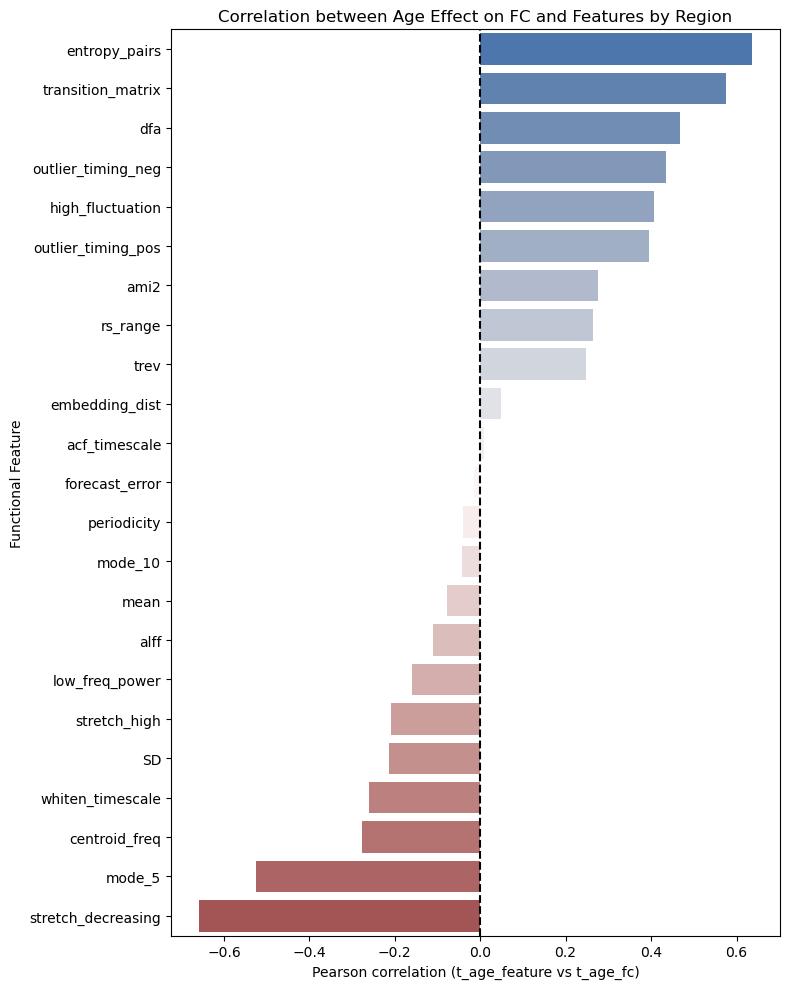

In [228]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,10))
sns.barplot(x='r_with_fc_age_effect', y='feature', data=results_df, palette='vlag')
plt.axvline(0, color='k', linestyle='--')
plt.title('Correlation between Age Effect on FC and Features by Region')
plt.xlabel('Pearson correlation (t_age_feature vs t_age_fc)')
plt.ylabel('Functional Feature')
plt.tight_layout()
plt.show()


fcorr


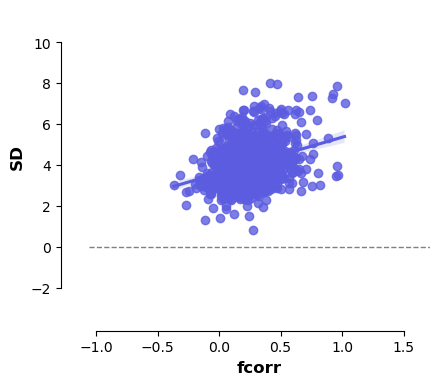

In [115]:
plot.lmplots(df_merged,
                 x_data="fcorr",#, 
                #color=colors_uniq[label],
                  y_data="SD",
             height=4,aspect=1,
             #xmin=-0.03,xmax=0.03,
                 #ymin=-0.1, ymax=0.5,
                     indiv_values=True,
                                  save=False)

In [113]:
from scipy.stats import spearmanr

results = []
merged_df["sex_num"] = merged_df["sex"].map({"F": 0, "M": 1})


for s_feat in structural_features:
    for f_feat in functional_features:
        r, p = spearmanr(merged_df[s_feat], merged_df[f_feat], nan_policy='omit')
        results.append({
            "structural_feature": s_feat,
            "functional_feature": f_feat,
            "spearman_r": r,
            "p_value": p
        })

results_df = pd.DataFrame(results)
significant = results_df[results_df["p_value"] < 0.05].sort_values(by="spearman_r", ascending=False)


In [114]:
significant

,structural_feature,functional_feature,spearman_r,p_value
20,MTR,mean,0.295155,1.910404e-27
21,MTR,SD,0.284825,1.358203e-25
22,MTR,alff,0.193375,2.243542e-12
113,RD,SD,0.114246,3.749849e-05
36,FA,centroid_freq,0.073321,8.277025e-03
32,FA,embedding_dist,0.069249,1.264699e-02
25,FA,acf_timescale,0.065168,1.896192e-02
43,FA,mean,0.059800,3.134666e-02
111,RD,forecast_error,0.058300,3.585433e-02
78,AD,embedding_dist,0.057666,3.792149e-02


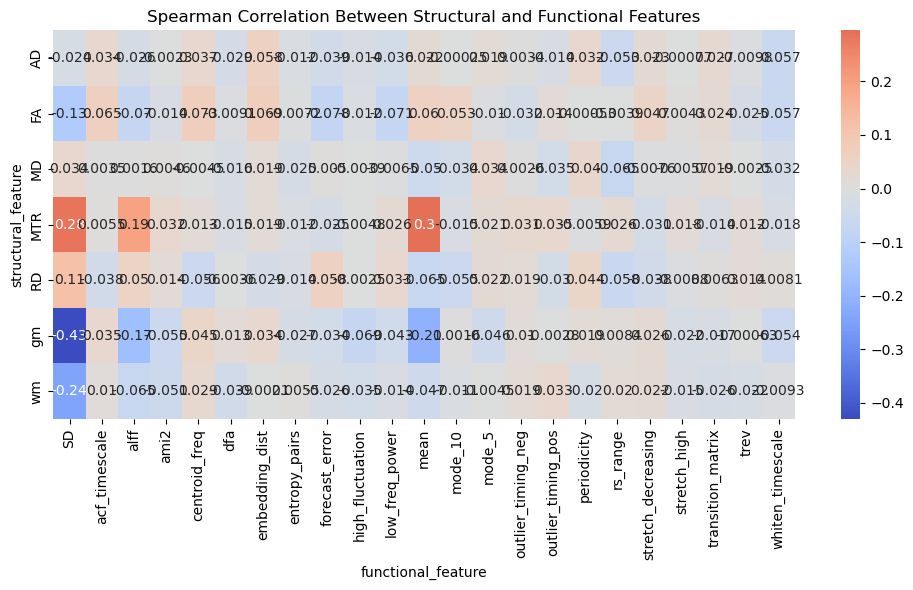

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create matrix for heatmap
pivot = results_df.pivot(index="structural_feature", columns="functional_feature", values="spearman_r")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlation Between Structural and Functional Features")
plt.tight_layout()
plt.show()


In [116]:
structural_features = ["MTR", "FA", "MD", "AD", "RD", "gm", "wm"]
#functional_features = ["mode_5", "mode_10", "alff", "forecast_error"]

results = []
merged_df["sex_num"] = merged_df["sex"].map({"F": 0, "M": 1})


for s_feat in structural_features:
    for f_feat in functional_features:
        formula_base = f"{f_feat} ~ {s_feat}"
        formula_adj = f"{f_feat} ~ {s_feat} + age + sex_num"
        
        model_base = smf.ols(formula_base, data=merged_df).fit()
        model_adj = smf.ols(formula_adj, data=merged_df).fit()
        
        results.append({
            "structural": s_feat,
            "functional": f_feat,
            "beta_struct_base": model_base.params[s_feat],
            "p_struct_base": model_base.pvalues[s_feat],
            "beta_struct_adj": model_adj.params[s_feat],
            "p_struct_adj": model_adj.pvalues[s_feat],
            "r2_base": model_base.rsquared,
            "r2_adj": model_adj.rsquared
        })

df_links = pd.DataFrame(results).sort_values(by="p_struct_adj")

pivot_vals = df_links.pivot(index="functional", columns="structural", values="beta_struct_adj")
pivot_sig = df_links.pivot(index="functional", columns="structural", values="p_struct_adj") < 0.05


/export02/data/tmp/ipykernel_3468268/1588784855.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ax = sns.heatmap(pivot_vals, annot=pivot_sig.applymap(lambda x: "*" if x else ""), fmt='',


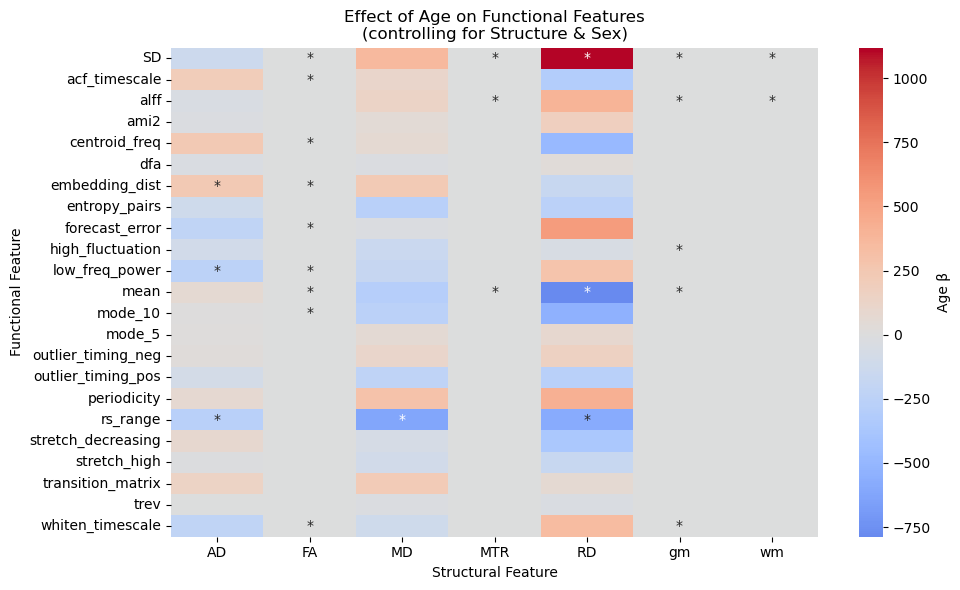

In [117]:
plt.figure(figsize=(10, 6))
ax = sns.heatmap(pivot_vals, annot=pivot_sig.applymap(lambda x: "*" if x else ""), fmt='', 
                 cmap="coolwarm", center=0, cbar_kws={'label': 'Age β'})
plt.title("Effect of Age on Functional Features\n(controlling for Structure & Sex)")
plt.xlabel("Structural Feature")
plt.ylabel("Functional Feature")
plt.tight_layout()
plt.show()


In [101]:
df_links

,structural,functional,beta_struct_base,p_struct_base,beta_struct_adj,p_struct_adj,r2_base,r2_adj
136,gm,SD,-8.337544e-03,8.480138e-66,-8.563655e-03,1.169713e-68,0.203017,0.242611
20,MTR,mean,1.913787e+01,2.073890e-29,1.969051e+01,1.351095e-30,0.093433,0.102986
21,MTR,SD,9.575354e-02,7.540063e-20,1.092910e-01,4.811958e-26,0.062319,0.119102
22,MTR,alff,1.146605e-02,1.997981e-13,1.162744e-02,1.752630e-13,0.040924,0.041290
137,gm,alff,-4.912497e-04,7.298459e-11,-5.218974e-04,1.622125e-11,0.032276,0.034646
...,...,...,...,...,...,...,...,...
92,RD,mode_5,1.673316e+01,8.271469e-01,-5.531713e+00,9.440072e-01,0.000037,0.001241
107,RD,entropy_pairs,-7.693528e-01,9.192446e-01,3.645076e-01,9.627342e-01,0.000008,0.000683
0,MTR,mode_5,-6.273608e-04,8.326320e-01,-8.520904e-05,9.773544e-01,0.000035,0.001257
154,wm,rs_range,-5.025035e-06,9.307162e-01,-1.253442e-06,9.827330e-01,0.000006,0.002530


#### <font color=#B14263>   ALFF and FC: age-related effects

0.410989010989011
0.14433266812460507
data1


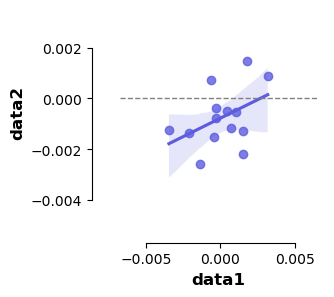

In [57]:
from brsc_statistics import Statistics 
stat_func=Statistics(config=config,ana_dir="",analysis="")
roi_results1=[];roi_results2=[]
all_df_nodes["rois"]

for roi in df_mean_alff["rois"].unique():
    print
    df_roi_metrics=df_mean_alff[df_mean_alff["rois"]==roi]
    signed_r2_1, p_age1, beta_age1,beta_sex1, stat_age1,stat_sex1,rsquare_age1=stat_func.signed_partial_r2(df=df_roi_metrics,y="alff",predictor="age",covariates=["sex"])
    roi_results1.append(beta_age1)
    signed_r2_2, p_age2, beta_age2,beta_sex2, stat_age2,stat_sex2,rsquare_age2=stat_func.signed_partial_r2(df=df_roi_metrics,y="fc",predictor="age",covariates=["sex"])
    roi_results2.append(beta_age2)

new_df=pd.DataFrame({"data1":roi_results1,"data2":roi_results2 })
new_df = new_df.dropna(subset=["data1", "data2"]).reset_index(drop=True)

r_value, p_value = spearmanr(new_df["data1"], new_df["data2"])
print(r_value)
print(p_value)
plot.lmplots(df=new_df,#color=["#dc8070"],
                 x_data="data1",
                 y_data="data2",
             height=3,
                 save=False)

#### <font color=#B14263> ALFF & microstructure

0.7956521739130433
3.3544542131570806e-06
MTR


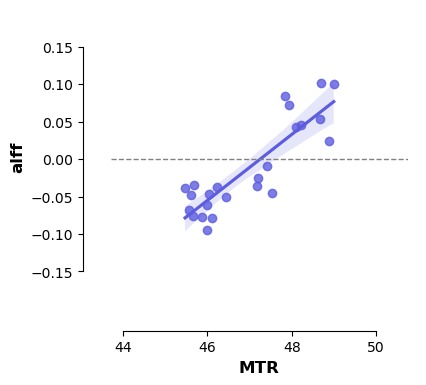

-0.6295652173913043
0.0009794901264482063
T2s_vx_gm


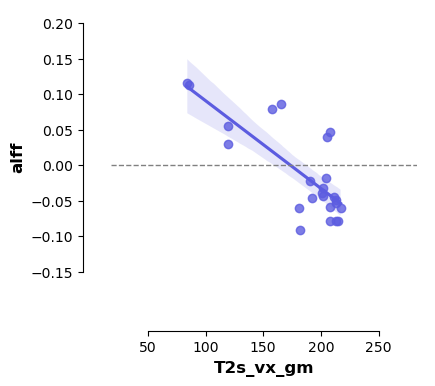

In [122]:
data_f={};data={};new_alff_df={}
data_f["MTR"]=main_dir+ "/../figures/f01_structural/mtr/2_second_level/MTR_by_cord_rois.csv"
data_f["MTR"]=main_dir+ "/../figures/f01_structural/12june25/mtr/2_second_level/roi_metric/n65_MTR.csv"
data_f["FA"]=main_dir+ "/../figures/f01_structural/dwi/2_second_level/FA_by_wm_rois.csv"
data_f["RD"]=main_dir+ "/../figures/f01_structural/dwi/2_second_level/RD_by_cord_rois.csv"
data_f["T2s_vx_gm"]=main_dir+ "/../figures/f01_structural/12june25/t2s/2_second_level/roi_metric/n67_T2s_vx_gm.csv"

for metric in ["MTR","T2s_vx_gm"]:
    data[metric]=pd.read_csv(data_f[metric])
    common_ids = set(np.unique(data[metric]["IDs"])) & set(np.unique(data_alff["IDs"]))
    data[metric]=data[metric][data[metric]["IDs"].isin(common_ids)].reset_index(drop=True)
    data[metric]=data[metric][data[metric]["levels"]!="C1"].reset_index(drop=True)
    new_alff_df[metric]=data_alff[data_alff["IDs"].isin(common_ids)].reset_index(drop=True)

    new_alff_df[metric]=new_alff_df[metric][new_alff_df[metric]["levels"]!="C1"].reset_index(drop=True)
    new_alff_df[metric][metric]=data[metric][metric]

    df=new_alff_df[metric].groupby(["rois"], as_index=False)[['alff',metric]].mean()
    r_value, p_value = spearmanr(df['alff'], df[metric])
    print(r_value); print(p_value)
    
    plot.lmplots(df,
                     x_data=metric,#, 
                    #color=colors_uniq[label],
                      y_data="alff",
                 height=4,aspect=1,
                 #xmin=-0.03,xmax=0.03,
                     #ymin=-0.1, ymax=0.5,
                         indiv_values=True,
                                      save=False)

<hr style="border:1px solid black">

### <font color=#B14263> B. Coupling between similarity matrices  
#### <font color=#B14263> Load structural and function similarity matrices

In [411]:
temp_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/figures/f02_functional_sc/features/sc_4June25/spinalcord/1_first_level/sim_matrix/"
fc_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/figures/f02_functional_sc/seed2seed_nostd/spinalcord/"
struct_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/figures/f01_structural/12june25/similarity/1_first_level/sim_matrix/"
population_info=config["main_dir"]  + "/2024_brsc_aging_project/config/participants_brsc_aging.tsv"
metadata = pd.read_csv(population_info, delimiter='\t')

common_ids = set(config["participants_IDs_DWI"]) & set(config["participants_IDs_MTR"]) & set(config["participants_IDs_T2s"])
IDs = sorted(list(common_ids))

temp_matrix_df=temp_dir + "sim_matrix.csv"

temp_f=[];temp_matrix=[];fc_f=[];fc_matrix=[];struct_f=[];struct_matrix=[];age=[];sex=[]
for ID_nb, ID in enumerate(IDs):
    temp_f.append(glob.glob(temp_dir + "sub-"+ID+"_sim_matrix_signif_age.csv")[0])
    temp_matrix.append(np.array(pd.read_csv(temp_f[ID_nb],header=None)))
    fc_f.append(glob.glob(fc_dir + "/1_first_level/correlation/sub-"+ID+"*_corr_matrix*.csv")[0])
    fc_matrix.append(np.array(pd.read_csv(fc_f[ID_nb],header=None)))
    struct_f.append(glob.glob(struct_dir + "sub-"+ID+"_sim_matrix.csv")[0])
    struct_matrix.append(np.array(pd.read_csv(struct_f[ID_nb],header=None)))
    age.append(metadata[metadata["participant_id"] == ID]["age"].values[0])
    sex.append(metadata[metadata["participant_id"] == ID]["sex"].values[0])

temp_matrix=np.array(temp_matrix);struct_matrix=np.array(struct_matrix)
fc_matrix=np.array(fc_matrix)

# load grouped df
struc_df=pd.read_csv(glob.glob(struct_dir + "sim_matrix_df_signif_age.csv")[0])
temp_df=pd.read_csv(glob.glob(temp_dir + "sim_matrix_df.csv")[0])
fc_df=pd.read_csv(glob.glob(fc_dir + "/2_second_level/correlation/n67_corr_concat_df_ALL_C1C7_quad_z_half.csv")[0])

In [412]:
struc_df

,IDs,age,sex,group,seed1,seed2,sim,labels1,labels2,level_labels,betwith_labels
0,A003,66,F,OA,C2_RD,C2_LD,1.559447,dorsal,dorsal,C2,intra
1,A003,66,F,OA,C2_RD,C3_RV,1.829554,right,within,NaN,inter
2,A003,66,F,OA,C2_RD,C3_LV,2.479010,cross1,cross,NaN,inter
3,A003,66,F,OA,C2_RD,C3_RD,1.127931,dorsal,dorsal,NaN,inter
4,A003,66,F,OA,C2_RD,C3_LD,0.695285,dorsal,dorsal,NaN,inter
...,...,...,...,...,...,...,...,...,...,...,...
12469,P109,56,M,MA,C7_RV,C7_RD,1.477831,right,within,C7,intra
12470,P109,56,M,MA,C7_RV,C7_LD,1.203940,cross2,cross,C7,intra
12471,P109,56,M,MA,C7_LV,C7_RD,1.454646,cross1,cross,C7,intra
12472,P109,56,M,MA,C7_LV,C7_LD,1.661419,left,within,C7,intra


#### <font color=#B14263> Compute coupling 

In [399]:
from brsc_statistics import Statistics
stat=Statistics(config=config,IDs=IDs,ana_dir="/")
df_temp_struct,data_temp_struc=stat.compute_regional_coupling(matrix1=temp_matrix[:, 4:, 4:],matrix2=struct_matrix,metrics=["temp","struc"],df_out=True,metadata_df=metadata)
df_fc_struct,data_fc_struc=stat.compute_regional_coupling(matrix1=fc_matrix[:, 4:, 4:],matrix2=struct_matrix,metrics=["fc","struc"],df_out=True,metadata_df=metadata)
df_fc_temp,data_fc_temp=stat.compute_regional_coupling(matrix1=fc_matrix[:, 4:, 4:],matrix2=temp_matrix[:, 4:, 4:],metrics=["fc","temp"],df_out=True,metadata_df=metadata)
data_fc_temp["struc"]=data_fc_struc["struc"]

/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project/code/brsc_statistics.py:111: RuntimeWarning: Mean of empty slice
  m1_all = np.stack(matrix1); m1_mean=np.nanmean(m1_all,axis=0)
/cerebro/cerebro1/dataset/bmpd/derivatives/Aging_project/2024_brsc_aging_project/code/brsc_statistics.py:112: RuntimeWarning: Mean of empty slice
  m2_all = np.stack(matrix2); m2_mean=np.nanmean(m2_all,axis=0)


#### <font color=#B14263> Plot regional coupling

temp


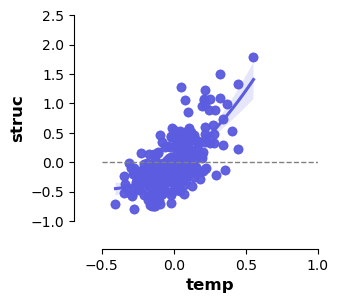

fc


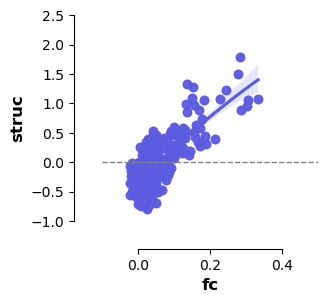

temp


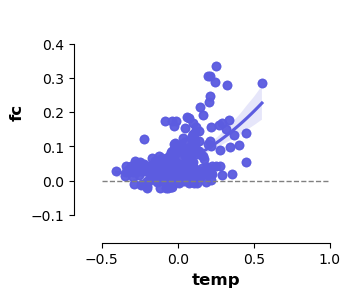

In [400]:
comparisons={"temp_struc":["temp","struc"],"fc_struc":["fc","struc"],"temp_fc":["temp","fc"]}
x_lim={"temp_struc":[-0.5,1],"fc_struc":[-0.1,0.5],"temp_fc":[-0.5,1]}
y_lim={"temp_struc":[-1,2.5],"fc_struc":[-1,2.5],"temp_fc":[-0.1,0.5]}

for comp in comparisons:
    plot.lmplots(df=data_fc_temp,#color=["#dc8070"],
                 x_data=comparisons[comp][0],
                 y_data=comparisons[comp][1],
             order=2,
             height=3,
             xmin=x_lim[comp][0],xmax=x_lim[comp][1],
            ymin=y_lim[comp][0], ymax=y_lim[comp][1],
                 indiv_values=True,
             #xy_plot=True,
                 #output_dir=outputdir,
                 #output_tag="br_vol_age_prediction",
                 save=False)


#### <font color=#B14263> Plot regional coupling agaisnt age

0.264117999362617
age


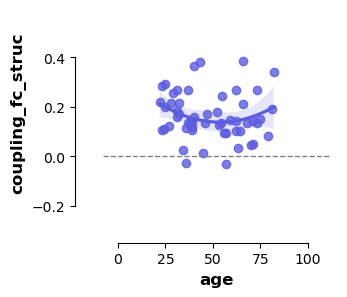

In [401]:
df_fc_temp["coupling_fc_temp"]=df_fc_temp["regional_coupling"]
df_fc_temp["coupling_fc_struc"]=df_fc_struct["regional_coupling"]
df_fc_temp["coupling_struc_temp"]=df_temp_struct["regional_coupling"]

metric="coupling_fc_struc"
df=df_fc_temp.groupby(["IDs","age","sex"])[[metric]].mean().reset_index()
df=df.dropna(subset=[metric]).reset_index(drop=True)

r_value, p_value = spearmanr(df[metric], df["age"])
print(p_value)

plot.lmplots(df=df,#color=["#dc8070"],
                 x_data="age",
                 y_data=metric,
             order=2,
             height=3, indiv_values=True,
             #xmin=x_lim[comp][0],xmax=x_lim[comp][1],
            #ymin=y_lim[comp][0], ymax=y_lim[comp][1],
             #xy_plot=True,
                 #output_dir=outputdir,
                 #output_tag="br_vol_age_prediction",
                 save=False)


In [345]:
excluded_rois = ["C1_RV", "C1_RD", "C1_LV", "C1_LD"]
common_ids = set(config["participants_IDs_DWI"]) & set(config["participants_IDs_MTR"]) & set(config["participants_IDs_T2s"])

df={}
df["structure"]=struc_df; df["func_temp"]=temp_df ; df["func_fc"]=fc_df
df["func_fc"]["seed1"]=df["func_fc"]["seed_names"]; df["func_fc"]["seed2"]=df["func_fc"]["target_names"]

for comp in ["structure","func_temp","func_fc"]:
    print(comp)
    df[comp]= df[comp][~df[comp]["seed1"].isin(excluded_rois) & ~df[comp]["seed2"].isin(excluded_rois)]
    df[comp]["couple_rois"]=df[comp]["seed1"] + "_" + df[comp]["seed2"] 


structure
func_temp
func_fc


/export02/data/tmp/ipykernel_2830823/1852148429.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[comp]["couple_rois"]=df[comp]["seed1"] + "_" + df[comp]["seed2"]
/export02/data/tmp/ipykernel_2830823/1852148429.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[comp]["couple_rois"]=df[comp]["seed1"] + "_" + df[comp]["seed2"]


In [402]:

df={}
#Selct the dataframe and create the couple_rois column
filt_temp_df = temp_df[~temp_df["seed1"].isin(excluded_rois) & ~temp_df["seed2"].isin(excluded_rois)]
filt_temp_df["couple_rois"]=filt_temp_df["seed1"] + "_" + filt_temp_df["seed2"] 
struc_df["couple_rois"]=struc_df["seed1"] + "_" + struc_df["seed2"] 
fc_df["couple_rois"]=fc_df["seed_names"] + "_" + fc_df["target_names"]; fc_df["seed1"]=fc_df["seed_names"]
df["structure"]=struc_df; df["func_temp"]=filt_temp_df ; df["func_fc"]=fc_df

 

/export02/data/tmp/ipykernel_2830823/1482272946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_temp_df["couple_rois"]=filt_temp_df["seed1"] + "_" + filt_temp_df["seed2"]


In [403]:

roi_results1=[];roi_results2=[];roi_results3=[]
for roi in struc_df["couple_rois"].unique():
    df_roi_metrics=struc_df[struc_df["couple_rois"]==roi]
    signed_r2_1, p_age1, beta_age1,beta_sex1, stat_age1,stat_sex1=stat_func.signed_partial_r2(df=df_roi_metrics,y="sim",predictor="age",covariates=["sex"])
    roi_results1.append(beta_age1)
    
    df_roi_metrics2=filt_temp_df[filt_temp_df["couple_rois"]==roi]
    signed_r2_2, p_age2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=df_roi_metrics2,y="sim",predictor="age",covariates=["sex"])
    roi_results2.append(beta_age2)

    df_roi_metrics3=fc_df[fc_df["couple_rois"]==roi]
    signed_r2_3, p_age3, beta_age3,beta_sex3, stat_age3,stat_sex3=stat_func.signed_partial_r2(df=df_roi_metrics3,y="corr",predictor="age",covariates=["sex"])
    roi_results3.append(beta_age3)

0.1464339258941958
0.026045013390222575
data1


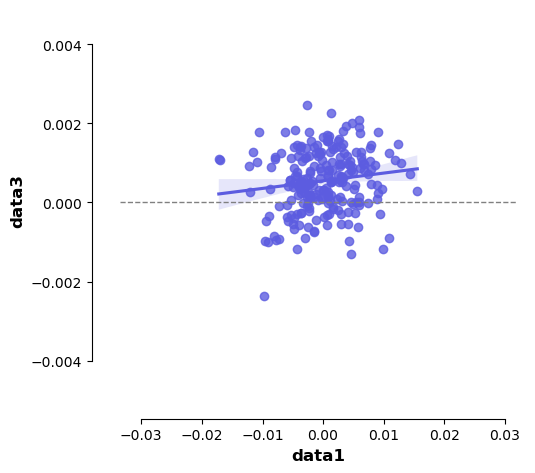

In [404]:
new_df=pd.DataFrame({"data1":roi_results1,"data2":roi_results2 ,"data3":roi_results3 })
new_df = new_df.dropna(subset=["data1", "data2","data3"]).reset_index(drop=True)

r_value, p_value = spearmanr(new_df["data1"], new_df["data3"])
print(r_value)
print(p_value)
plot.lmplots(df=new_df,#color=["#dc8070"],
                 x_data="data1",
                 y_data="data3",
             height=5,indiv_values=True,
                 save=False)

In [405]:
fc_df
struc_df

,IDs,age,sex,group,seed1,seed2,sim,labels1,labels2,level_labels,betwith_labels,couple_rois
0,A003,66,F,OA,C2_RD,C2_LD,1.511168,dorsal,dorsal,C2,intra,C2_RD_C2_LD
1,A003,66,F,OA,C2_RD,C3_RV,1.756915,right,within,NaN,inter,C2_RD_C3_RV
2,A003,66,F,OA,C2_RD,C3_LV,2.298380,cross1,cross,NaN,inter,C2_RD_C3_LV
3,A003,66,F,OA,C2_RD,C3_RD,0.758405,dorsal,dorsal,NaN,inter,C2_RD_C3_RD
4,A003,66,F,OA,C2_RD,C3_LD,0.705666,dorsal,dorsal,NaN,inter,C2_RD_C3_LD
...,...,...,...,...,...,...,...,...,...,...,...,...
12469,P109,56,M,MA,C7_RV,C7_RD,1.453505,right,within,C7,intra,C7_RV_C7_RD
12470,P109,56,M,MA,C7_RV,C7_LD,1.169399,cross2,cross,C7,intra,C7_RV_C7_LD
12471,P109,56,M,MA,C7_LV,C7_RD,1.352709,cross1,cross,C7,intra,C7_LV_C7_RD
12472,P109,56,M,MA,C7_LV,C7_LD,1.591873,left,within,C7,intra,C7_LV_C7_LD


In [408]:
filt_fc_df=fc_df[~fc_df["seed_names"].isin(excluded_rois) & ~fc_df["target_names"].isin(excluded_rois)].reset_index(drop=True)
filt_fc_df

,IDs,group,age,sex,seed_names,target_names,corr,fcorr,zfcorr,labels1,level_labels,distance_labels,betwith_labels,couple_rois,seed1
0,A001,MA,58,F,C2_RV,C2_LV,0.124764,0.125418,0.743191,ventral,C2,0.0,intra,C2_RV_C2_LV,C2_RV
1,A001,MA,58,F,C2_RV,C2_RD,0.305631,0.315720,2.426219,within,C2,0.0,intra,C2_RV_C2_RD,C2_RV
2,A001,MA,58,F,C2_RV,C2_LD,0.180955,0.182970,1.252181,cross,C2,0.0,intra,C2_RV_C2_LD,C2_RV
3,A001,MA,58,F,C2_RV,C3_RV,0.164230,0.165731,1.099722,ventral,NaN,1.0,inter,C2_RV_C3_RV,C2_RV
4,A001,MA,58,F,C2_RV,C3_LV,0.069398,0.069509,0.248739,ventral,NaN,1.0,inter,C2_RV_C3_LV,C2_RV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18487,P109,MA,56,M,C7_RV,C7_RD,-0.000525,-0.000525,-0.604758,within,C7,0.0,intra,C7_RV_C7_RD,C7_RV
18488,P109,MA,56,M,C7_RV,C7_LD,-0.025124,-0.025129,-0.841268,cross,C7,0.0,intra,C7_RV_C7_LD,C7_RV
18489,P109,MA,56,M,C7_LV,C7_RD,-0.054706,-0.054761,-1.126109,cross,C7,0.0,intra,C7_LV_C7_RD,C7_LV
18490,P109,MA,56,M,C7_LV,C7_LD,0.123619,0.124254,0.594708,within,C7,0.0,intra,C7_LV_C7_LD,C7_LV


In [389]:
filt_fc_df=fc_df[~fc_df["seed_names"].isin(excluded_rois) & ~fc_df["target_names"].isin(excluded_rois)].reset_index(drop=True)


signed_r2_1, p_age1, beta_age1,beta_sex1, stat_age1,stat_sex1=stat_func.signed_partial_r2(df=filt_fc_df,y="fcorr",predictor="age",covariates=["sex"],random="IDs")

    
signed_r2_2, p_age2, beta_age2,beta_sex2, stat_age2,stat_sex2=stat_func.signed_partial_r2(df=struc_df,y="sim",predictor="age",covariates=["sex"],random="IDs")


#signed_r2_3, p_age3, beta_age3,beta_sex3, stat_age3,stat_sex3=stat_func.signed_partial_r2(df=fc_df,y="corr",predictor="age",covariates=["sex"],random="IDs")


IndexError: index 12453 is out of bounds for axis 0 with size 12453

In [204]:
len(new_df)

253

In [ ]:
r_value, p_value = pearsonr(beta1_flat[valid], beta2_flat[valid])
print(r_value)
print(p_value)

In [369]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_nodes = beta_age_1.shape[0]

# Extract upper triangle indices (excluding diagonal)
triu_idx = np.triu_indices(n_nodes, k=1)

# Flatten the beta_age matrices at upper triangle
beta1_flat = beta_age_1[triu_idx]
beta2_flat = beta_age_2[triu_idx]

# Filter valid (non-NaN) entries
valid = np.isfinite(beta1_flat) & np.isfinite(beta2_flat)


# Plot scatter + regression line
plt.figure(figsize=(7,7))
sns.regplot(x=beta1_flat[valid], y=beta2_flat[valid],
            scatter_kws={'s':30, 'alpha':0.6}, line_kws={'color':'red'})

plt.xlabel('Age Beta Coefficients Matrix 1')
plt.ylabel('Age Beta Coefficients Matrix 2')
plt.title('Correlation of Age Effects Between Two Matrices')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'beta_age_1' is not defined

In [191]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
mat1=struct_matrix 
mat2=temp_matrix[:, 4:, 4:]
n_subjects, n_nodes, _ = mat1.shape

# Convert categorical sex to binary if needed
sex_binary = pd.Series(sex).map({'M': 1, 'F': 0}).values


# Output matrices for age beta and p-values
beta_age_1 = np.full((n_nodes, n_nodes), np.nan)
pval_age_1 = np.full((n_nodes, n_nodes), np.nan)
beta_age_2 = np.full((n_nodes, n_nodes), np.nan)
pval_age_2 = np.full((n_nodes, n_nodes), np.nan)

for i in range(n_nodes):
    for j in range(i, n_nodes):
        for mat, beta_out, pval_out in zip([mat1, mat2], 
                                           [beta_age_1, beta_age_2],
                                           [pval_age_1, pval_age_2]):
            y = mat[:, i, j]
            valid = np.isfinite(y) & np.isfinite(age) & np.isfinite(sex_binary)
            if np.sum(valid) > 2:
                df = pd.DataFrame({
                    'y': y,
                    'age': age,
                    'sex': sex_binary
                })
                model = sm.OLS(df['y'], sm.add_constant(df[['age', 'sex']])).fit()
                beta_out[i, j] = model.params['age']
                pval_out[i, j] = model.pvalues['age']
                # optional: make symmetric
                beta_out[j, i] = beta_out[i, j]
                pval_out[j, i] = pval_out[i, j]


In [200]:
24*23/2


276.0

0.12675470874607
0.04397753527691771


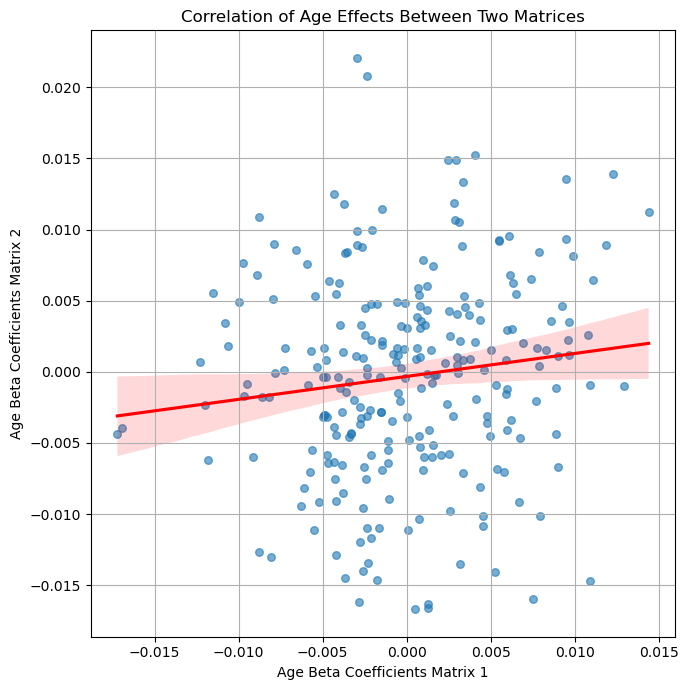

In [192]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_nodes = beta_age_1.shape[0]

# Extract upper triangle indices (excluding diagonal)
triu_idx = np.triu_indices(n_nodes, k=1)

# Flatten the beta_age matrices at upper triangle
beta1_flat = beta_age_1[triu_idx]
beta2_flat = beta_age_2[triu_idx]

# Filter valid (non-NaN) entries
valid = np.isfinite(beta1_flat) & np.isfinite(beta2_flat)
r_value, p_value = pearsonr(beta1_flat[valid], beta2_flat[valid])
print(r_value)
print(p_value)

# Plot scatter + regression line
plt.figure(figsize=(7,7))
sns.regplot(x=beta1_flat[valid], y=beta2_flat[valid],
            scatter_kws={'s':30, 'alpha':0.6}, line_kws={'color':'red'})

plt.xlabel('Age Beta Coefficients Matrix 1')
plt.ylabel('Age Beta Coefficients Matrix 2')
plt.title('Correlation of Age Effects Between Two Matrices')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

mat1 = fc_matrix[:, 4:, 4:]
mat2 = temp_matrix[:, 4:, 4:]
n_subjects, n_nodes, _ = mat1.shape

sex_binary = pd.Series(sex).map({'M': 1, 'F': 0}).values

partial_r2_1 = np.full((n_nodes, n_nodes), np.nan)
partial_r2_2 = np.full((n_nodes, n_nodes), np.nan)
beta_age_1 = np.full((n_nodes, n_nodes), np.nan)
beta_age_2 = np.full((n_nodes, n_nodes), np.nan)

for i in range(n_nodes):
    for j in range(i, n_nodes):
        for mat, pr2_out, beta_out in zip([mat1, mat2], 
                                          [partial_r2_1, partial_r2_2],
                                          [beta_age_1, beta_age_2]):
            y = mat[:, i, j]
            #valid = np.isfinite(y) & np.isfinite(age) & np.isfinite(sex_binary)

            if np.sum(valid) > 5:
                df = pd.DataFrame({
                    'y': y,
                    'age': age,
                    'sex': sex_binary
                })

                full_model = sm.OLS(df['y'], sm.add_constant(df[['age', 'sex']])).fit()
                
                # Only compute partial R² if age is significant
                if full_model.pvalues['age'] < 0.05:
                    reduced_model = sm.OLS(df['y'], sm.add_constant(df[['sex']])).fit()

                    SS_full = np.sum(full_model.resid ** 2)
                    SS_reduced = np.sum(reduced_model.resid ** 2)
                    SS_total = np.sum((df['y'] - df['y'].mean()) ** 2)

                    if SS_total > 1e-10:
                        partial_r2 = (SS_reduced - SS_full) / SS_total
                        pr2_out[i, j] = partial_r2
                        beta_out[i, j] = full_model.params['age']
                        # Symmetrize
                        pr2_out[j, i] = partial_r2
                        beta_out[j, i] = full_model.params['age']
                    else:
                        pr2_out[i, j] = np.nan
                        pr2_out[j, i] = np.nan
                        beta_out[i, j] = np.nan
                        beta_out[j, i] = np.nan
                else:
                    # Not significant: set as NaN
                    pr2_out[i, j] = np.nan
                    pr2_out[j, i] = np.nan
                    beta_out[i, j] = np.nan
                    beta_out[j, i] = np.nan


In [31]:
beta1_flat

array([0.07759551,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.08915338,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.13691766, 0.09523281,        nan,        nan,
              nan,        nan, 0.06364056,        nan,        nan,
              nan,        nan,        nan,        nan, 0.10425742,
       0.10482994,        nan,        nan,        nan,        nan,
              nan, 0.08164771,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [9]:
from scipy.stats import pearsonr

# Using the same beta1_flat, beta2_flat and valid from before
beta1_valid = beta1_flat[valid]
beta2_valid = beta2_flat[valid]

# Compute Pearson correlation and p-value
r_value, p_value = pearsonr(beta1_valid, beta2_valid)

print(f"Pearson r = {r_value:.3f}, p = {p_value:.3e}")


ValueError: x and y must have length at least 2.

In [ ]:
#r pour chaque node (age effect) for fc and 

                            OLS Regression Results                            
Dep. Variable:      regional_coupling   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     7.681
Date:                Wed, 11 Jun 2025   Prob (F-statistic):            0.00121
Time:                        11:05:54   Log-Likelihood:                 8.0589
No. Observations:                  54   AIC:                            -10.12
Df Residuals:                      51   BIC:                            -4.151
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5606      0.090      6.215      0.0

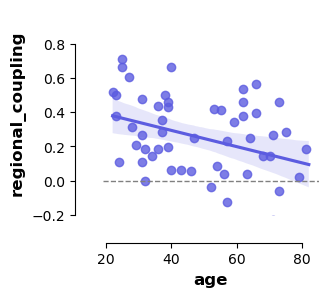

#### <font color=#B14263> Compute coupling at the group level

In [ ]:
## divide into within or between networks: significan for within and structure
nodes_per_network = 4
n_networks = n_nodes // nodes_per_network
for matrix in [temp_matrix, fc_matrix, struct_matrix]:
    

    within_matrices = []
    between_matrices = []
    
    for mat in matrix:  # loop over subjects
        mat = np.array(mat)
        
        # Create masks
        within_mask = np.full((n_nodes, n_nodes), False)
        for i in range(n_networks):
            idx = slice(i * nodes_per_network, (i + 1) * nodes_per_network)
            within_mask[idx, idx] = True
        
        between_mask = ~within_mask
    
        # Apply masks
        within_mat = np.where(within_mask, mat, np.nan)
        between_mat = np.where(between_mask, mat, np.nan)
    
        within_matrices.append(within_mat)
        between_matrices.append(between_mat)

    if matrix is temp_matrix:
        temp_matrix_within=np.array(within_matrices)
        temp_matrix_between=np.array(between_matrices)
    elif matrix is fc_matrix:
        fc_matrix_within=np.array(within_matrices)
        fc_matrix_between=np.array(between_matrices)
    elif matrix is struct_matrix:
        struct_matrix_within=np.array(within_matrices)
        struct_matrix_between=np.array(between_matrices)

df_temp_struct=stat.compute_regional_coupling(matrix1=temp_matrix_within,matrix2=struct_matrix_within,df_out=True,metadata_df=metadata)
df_fc_struct=stat.compute_regional_coupling(matrix1=fc_matrix_within,matrix2=struct_matrix_within,df_out=True,metadata_df=metadata)
df_fc_temp=stat.compute_regional_coupling(matrix1=fc_matrix_within,matrix2=temp_matrix_within,df_out=True,metadata_df=metadata)

# Average local coupling across nodes for each individual
df=df_fc_struct

df_subject = df.groupby("participant_id").agg({
    "regional_coupling": "mean",
    "age": "first",
    "sex": "first"
}).reset_index()
model = smf.ols("regional_coupling ~ age + sex", data=df_subject).fit()
print(model.summary())

plot.lmplots(df=df_subject,#color=["#dc8070"],
                 x_data="age",
                 y_data="regional_coupling",xmin=19,xmax=85,
                 ymin=-0.2, ymax=1,xy_plot=True,
                 #output_dir=outputdir,
                 #output_tag="br_vol_age_prediction",
                 save=False)